# Via expressa para ônibus urbano

In [31]:
from _thread import *
from IPython.display import IFrame

import time
import random
import threading
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Configuração para o algoritmo genético

In [32]:
totGeracoes  = 500
tamPopulacao = 50


indCruzamento = 10
CXPB = 0.5
MUTPB = 0.15
PROB_MUTACAO = 0.15
removerPior = 0

recebeAjuda  = False

feature1 = 1.0
feature2 = 1.0
feature3 = 1.0

# Formato Imagens

In [33]:
'''
    Formatos Suportados salvar rotas e mapas: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz 
'''
formato_imgs = 'pdf'

# Configuração da Imagens

In [34]:
'''
    configuração da imagens
'''
edge_color = "#000000"         # cor da aresta
bgcolor    = "#D3D3D3"     # cor do background
node_color = "#9370DB"     # cor da vértice
node_size  = 30            # Tamanho do vértice
fig_height = 20           # altura figura
fig_width  = 20           # largura figura

# Localização para o OSMNX gerar o Grafo

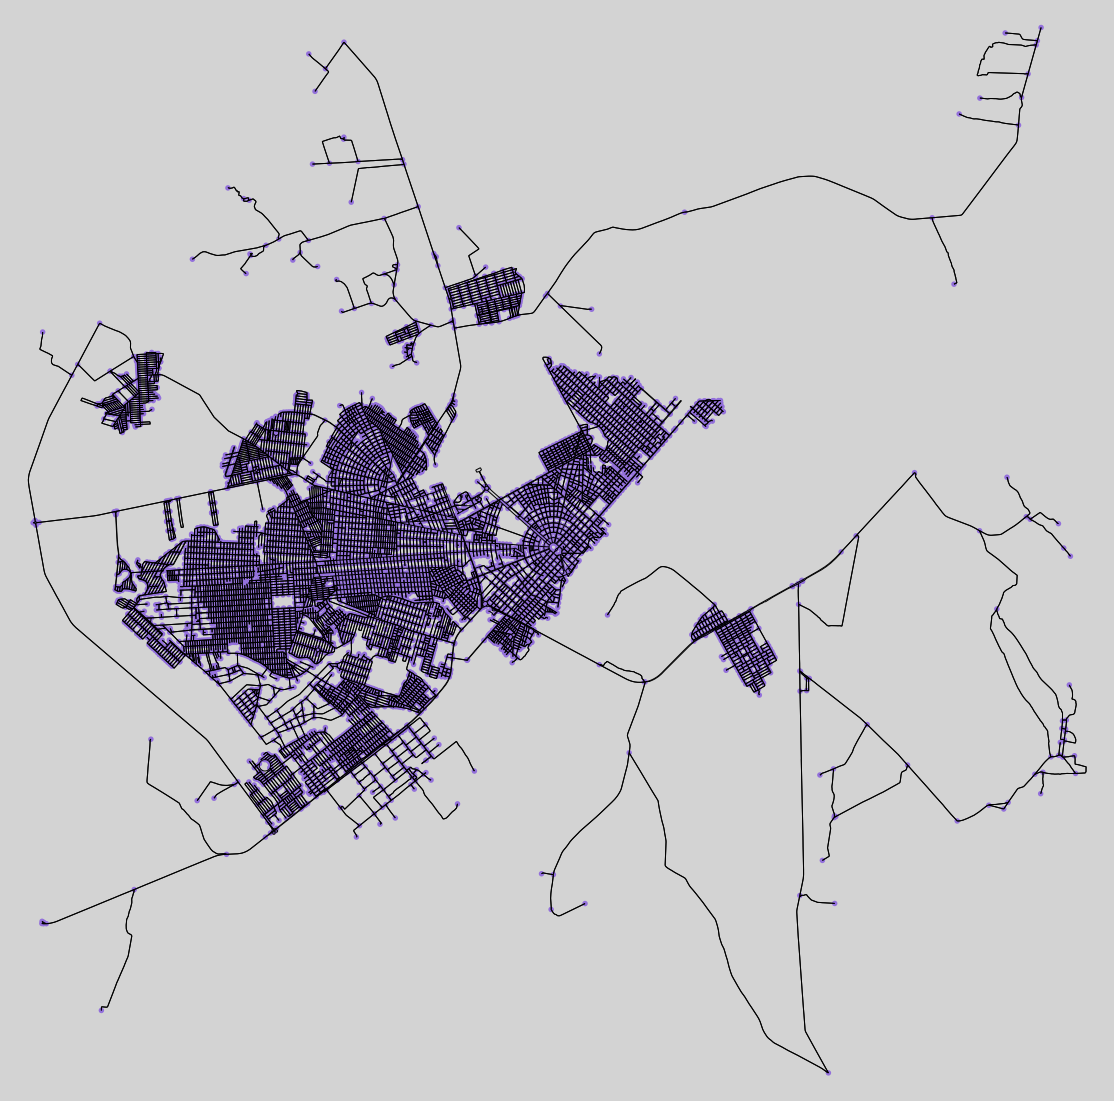

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99e9e52630>)

In [35]:
place = 'Boa Vista, Roraima, BR'
Raio_distancia = 15000

G = ox.graph_from_address( place, network_type='drive', simplify=True, distance=Raio_distancia )

ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaCompleto", save=True, file_format=formato_imgs)

# Vértice que representa o terminal de ônibus

In [36]:
nodosCentroCivico = (3648084763,3648084762)
nodoAdjTerminal   = (3648084763,3589958315)

# Extrai as informações das via do Grafo G

In [37]:
listaDados = []

dado = G.adj
for i in dado:
    for j in dado[i]:
        for k in dado[i][j]:
            #print()
            #print(dado[i][j][k])
            h = []
            h.append(i)
            h.append(j)
            h.append(dado[i][j][k])
            listaDados.append(h)

# Gera uma lista com as pontuações que cada aresta recebeu dentre as suas características

In [38]:
listaValores = []
valorRuim = -1

for i in listaDados:
    soma = 0
    
    if "highway" in i[2]:
        if i[2]['highway'] == "primary": #ex: avenida venezuela
            soma = 1
        elif i[2]['highway'] == "secondary": #ex: Major Williams
            soma = 1
        elif i[2]['highway'] == "tertiary": #ex: Rua General Penha Brasil
            soma = 1
        else:
            soma = valorRuim
    
    
    listaValores.append(soma)

# Separa os vértices que não conseguiram atingir a pontuação mínima para remoção do Grafo

In [39]:
remover = []

for i in range(len(listaValores)):
    if listaValores[i] <= removerPior:
        remover.append( (listaDados[i][0], listaDados[i][1]))
        
G.remove_edges_from(remover)

# Atualiza a lista de arestas que estão aptas a serem selecionadas

In [40]:
listaValoresNew = []
listaDadosNew = []

for i in range(len(listaDados)):
    if listaValores[i] >= removerPior:
        listaValoresNew.append( listaValores[i] )
        listaDadosNew.append( listaDados[i] )

#remover os dados antigos para devolver memória
listaDados.clear()
listaValores.clear()
print(len(listaValoresNew))

7031


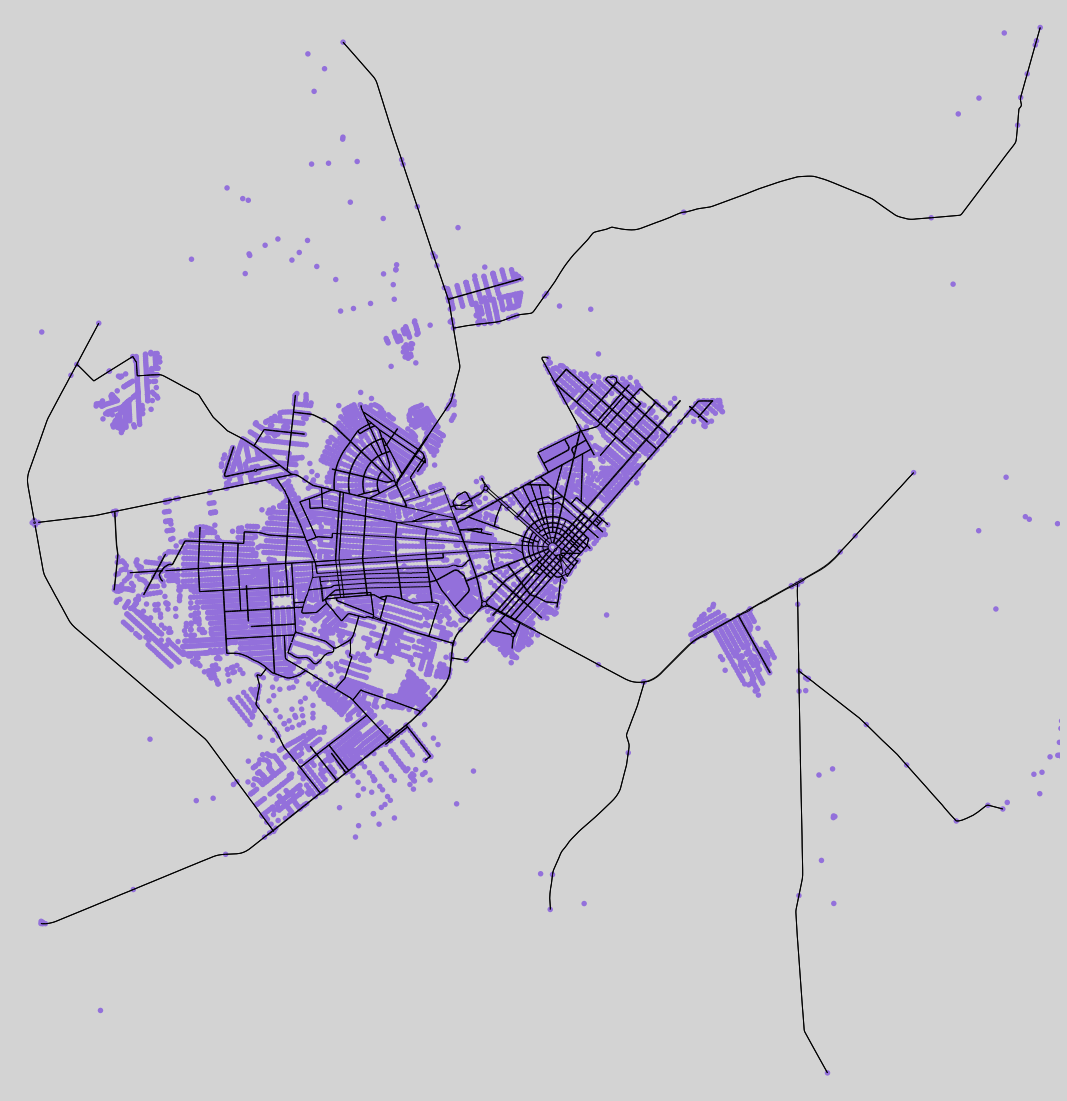

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99e8069710>)

In [41]:
ox.plot_graph(G, fig_height=fig_height, fig_width=fig_width, edge_color=edge_color, bgcolor=bgcolor, node_color=node_color, node_size=node_size, filename="mapaFiltrado", save=True,  file_format=formato_imgs)

# Lista que receberá os caminhos encontrados pelo AG

In [42]:
listaResultadoDFS = []
tamanhoDosCiclosSalvos = []

# Lista para salvar as informações da evolução do AG para plotagem de gráfico ao final do experimento

In [43]:
PlotMinDadosONEMAX  = []
PlotMeanDadosONEMAX = []
PlotMaxDadosONEMAX  = []

PlotMinDadosDFS  = []
PlotMeanDadosDFS = []
PlotMaxDadosDFS  = []

PlotMinDistDFS = []
PlotMeanDistDFS = []
PlotMaxDistDFS = []

PlotTempoExecucao = []

# Controle dos ciclos

In [44]:
PlotMaioresCiclos = []
PlotMaioresCiclos.append(0)

In [45]:
tamGenes = len(listaValoresNew)

# Busca em profundidade que encontrará os caminhos caso exista

In [46]:
def DFS_BuscaCiclo(grafo, mapa, mapaGrafo, verticeInicial, tamGrafo):
    
    import stack    
    pilha = stack.stack()
    v = verticeInicial
    
    #vetor de marcação de visitados e de elementos que estão na pilha O(1)
    visitados = []
    pilha_rec = []
    
    for i in range(tamGrafo):
        visitados.append(False)
        pilha_rec.append(False)
    
        
    it = -1
    contListaPercorrida = 0
    contDistPercorrida  = 0
    semDistancia = 0
    listaPercorrida = []
    controleMaiorCiclo = PlotMaioresCiclos[-1]
    
    #inicio da BFS
    while True:
        achou_vizinho = False        
        
        listaPercorrida.append(v)
        contListaPercorrida += 1
                
        if not visitados[ mapa[ v ] ]:
            x = mapa[ v ]
            
            pilha.empilhar( x )
            visitados[ x ] = True
            pilha_rec[ x ] = True
            
            
        for it in grafo[v]:
            
            #se tiver na pilha é porque possue ciclo - Achou um Ciclo          
            if it == verticeInicial:
                
                listaArestasCiclo = []
                
                for k in listaPercorrida:
                    if pilha_rec[ mapa[ k ] ] == True:
                        listaArestasCiclo.append( k )
                        
                tamList = len( listaArestasCiclo )
                
                '''
                    sempre salva ciclos maiores!
                '''
                if tamList > controleMaiorCiclo:
                    controleMaiorCiclo = tamList
                    
                    PlotMaioresCiclos.append( controleMaiorCiclo )
                                                        
                    '''
                        Pega o ciclo para salvar
                    '''
                    
                    cicloAtual = []
                    
                    for k in range(1, len(listaArestasCiclo)):
                        cicloAtual.append( (listaArestasCiclo[k-1], listaArestasCiclo[k]) )
                    cicloAtual.append( ( listaArestasCiclo[-1], listaArestasCiclo[0] ) )
                    
                    cicloAtualList = list( cicloAtual )
                    listaResultadoDFS.append( cicloAtualList )
                    tamanhoDosCiclosSalvos.append( tamList )
                
                    
            if not visitados[ mapa[ it ] ]:
                achou_vizinho = True
                break
                
        if not achou_vizinho:
            pilha_rec[ pilha.topo() ] = False
                
            pilha.desempilhar()
            
            if pilha.p_vazia():
                break
                
            v = mapaGrafo[ pilha.topo() ]
        
        else:
            # -------- pegar a distancia de A -> B ---------
            # do vertice A
            verticeAtual = v
            # para o vertice B
            verticeNovo  = it
            
            
            try:

                '''
                    Pegar a distancia percorrida pela DFS..
                '''
                            
                for lista_i in range(tamGenes):            
                    if( listaDadosNew[lista_i][0] == verticeAtual and listaDadosNew[lista_i][1] == verticeNovo ):

                        if 'length' in listaDadosNew[lista_i][2]:
                            lenghtAresta = float(listaDadosNew[lista_i][2]['length'])
                            contDistPercorrida  = float(contDistPercorrida + lenghtAresta)
                        else:
                            semDistancia = semDistancia + 1
            except:
                print("Erro na distancia...")
            
            
            
            # ---------------------------------------------
            
            # da busca em profundidade troca o vertice para o proximo
            # ---- NAO mexer ----------
            v =  it
            # -------------------------
    
    '''
        calcular a distancia achada + a media das distancias nao achadas
    '''
    
    
    # distancia percorrida
    distanciaFinal = ( contDistPercorrida ) + ( 15 * semDistancia )
    #print("Distancia percorrida: {}".format(distanciaFinal))   
    
    '''
        Falta retornar a distancia percorrida junto com a contListaPercorrida
    '''
    
    # Retorna a quantidade de arestas visitadas na busca em profundidade
    return contListaPercorrida, distanciaFinal

# Função que executa um filtro para remover as arestas não selecionadas pelo AG e envia a DFS para validação de rotas

In [47]:
def temCicloDFS(individuo):
    
    G_aux = G.copy()
    
    # ajuda na evolução do onemax
    if recebeAjuda:
        for i in range(50):            
            posicao = random.randint(0,tamGenes-1)
            individuo[posicao] = 1
        
        
                
    #identificador da posicao do nodo centro cívico para verificar se esta ativo
    ja_1 = False
    ja_2 = False
    for i in range(tamGenes):
        if listaDadosNew[i][0] == nodosCentroCivico[0] and listaDadosNew[i][1] == nodosCentroCivico[1]:
            individuo[i] = 1
            ja_1 = True
        if listaDadosNew[i][0] == nodoAdjTerminal[0] and listaDadosNew[i][1] == nodoAdjTerminal[1]:
            individuo[i] = 0
            ja_2 = True
        if ja_1 and ja_2:
            break
            
    
    #lista para remover os nós não selecionados pelo AG
    listaRemover = []            
        
    #Seleção dos nodos não selecionados
    #for i in range(len(individuo)):
    for i in range(tamGenes):
        if individuo[i] == 0:
            listaRemover.append( (listaDadosNew[i][0], listaDadosNew[i][1]) )
            
    #Remove os nodos não selecionados pelo AG
    G_aux.remove_edges_from( listaRemover )
    
    
    
    #listaMapa recebe os valores de [0 a totNodos]
    listaMapa = []
    for i in range(len(G_aux.nodes)):
        listaMapa.append(i)
    
    
    # 215151515 --> 10
    mapa = pd.Series(index=G_aux.nodes, data=listaMapa)
    # 10 --> 215151515
    mapaGrafo = pd.Series(G_aux.nodes)
    
    return DFS_BuscaCiclo(G_aux, mapa, mapaGrafo, nodosCentroCivico[0], len(G_aux.nodes))

In [48]:
#feature 1

def calc_objetivo_1(id, l_onemax):
    minimo = int(np.min(l_onemax))
    maximo = int(np.max(l_onemax))
    media  = int(np.mean(l_onemax))
    #print("ONEMAX:\t{}\t{}\t{}".format(minimo,media , maximo))
    PlotMinDadosONEMAX.append(minimo)
    PlotMeanDadosONEMAX.append(media)
    PlotMaxDadosONEMAX.append(maximo)

In [49]:
#feature 2

def calc_objetivo_2(id, l_dfs):
    minimo = int(np.min(l_dfs))
    maximo = int(np.max(l_dfs))
    media  = int(np.mean(l_dfs))
    #print("DFS:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinDadosDFS.append(minimo)
    PlotMeanDadosDFS.append(media)
    PlotMaxDadosDFS.append(maximo)

In [50]:
#feature 3

def calc_objetivo_3(id, l_dist):
    minimo = int(np.min(l_dist))
    maximo = int(np.max(l_dist))
    media  = int(np.mean(l_dist))
    #print("DIST:\t{}\t{}\t{}".format(minimo,media , maximo))
    # Grafico
    PlotMinDistDFS.append(minimo)
    PlotMeanDistDFS.append(media)
    PlotMaxDistDFS.append(maximo)

In [51]:
def timeExecuteGeneration(tempoInicio):
    tempoFinal = time.time()
    tempototal = tempoFinal - tempoInicio
    PlotTempoExecucao.append(tempototal)
    print("TEMPO - {}".format(tempototal))

# DEAP - ONEMAX

In [52]:
from deap import base
from deap import creator
from deap import tools
from deap import creator, base, tools, algorithms
import random


In [53]:
#1) onemax
#2) DFS
#3) distancia percorrida DFS

creator.create("FitnessMulti", base.Fitness, weights=(feature1, feature2, feature3))
creator.create("Individual", list, fitness=creator.FitnessMulti)

def evalFitness(individual):
    tamDFS, distanciaDFS = temCicloDFS(individual)
    return np.sum(individual), tamDFS, distanciaDFS
    #return np.sum(individual), temCicloDFS(individual)


toolbox = base.Toolbox()
toolbox.register("bit", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.bit, tamGenes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=tamPopulacao)
toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)




def main():
    random.seed(64)
    population = toolbox.population()
    fits = toolbox.map(toolbox.evaluate, population)
    
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit
    
    print("Start of evolution")
            
    for gen in range(totGeracoes):
        
        tempoInicio = time.time()
        
        print('GEN: {}'.format(gen+1))
        offspring = algorithms.varOr(population, toolbox, lambda_=tamPopulacao, cxpb=0.5, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        
        l_onemax = []
        l_dfs = []
        l_dist = []
        
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit            
            x, y, z = fit
            l_onemax.append(x)
            l_dfs.append(y)
            l_dist.append(z)
            #print("{}  {} {}".format(x, y, z))
            
        population = toolbox.select(offspring + population, k=tamPopulacao)
        
        
        # ONEMAX
        #calc_objetivo_1(l_onemax)        
        thread_ob_1 = threading.Thread(target=calc_objetivo_1, args=[1,l_onemax])
        thread_ob_1.start()
        
        # DFS
        #calc_objetivo_2(l_dfs)
        thread_ob_2 = threading.Thread(target=calc_objetivo_2, args=[2,l_dfs])
        thread_ob_2.start()
        
        # DISTÂNCIA
        #calc_objetivo_3(l_dist)
        thread_ob_3 = threading.Thread(target=calc_objetivo_3, args=[3,l_dist] )
        thread_ob_3.start()
        
        
        timeExecuteGeneration(tempoInicio)
        
        
    print("-- End of (successful) evolution --")
        
if __name__ == "__main__":
    main()

Start of evolution
GEN: 1
TEMPO - 5.525130748748779
GEN: 2
TEMPO - 5.486486911773682
GEN: 3
TEMPO - 5.726642608642578
GEN: 4
TEMPO - 5.9618847370147705
GEN: 5
TEMPO - 6.180953502655029
GEN: 6
TEMPO - 6.453864097595215
GEN: 7
TEMPO - 6.5862531661987305
GEN: 8
TEMPO - 6.485776901245117
GEN: 9
TEMPO - 6.6041693687438965
GEN: 10
TEMPO - 7.4162757396698
GEN: 11
TEMPO - 7.83968710899353
GEN: 12
TEMPO - 7.393576383590698
GEN: 13
TEMPO - 7.778048038482666
GEN: 14
TEMPO - 7.143458127975464
GEN: 15
TEMPO - 7.183936595916748
GEN: 16
TEMPO - 7.618870973587036
GEN: 17
TEMPO - 7.762683391571045
GEN: 18
TEMPO - 8.397042512893677
GEN: 19
TEMPO - 8.00086522102356
GEN: 20
TEMPO - 8.515058040618896
GEN: 21
TEMPO - 8.098846673965454
GEN: 22
TEMPO - 7.9905524253845215
GEN: 23
TEMPO - 8.168405771255493
GEN: 24
TEMPO - 7.9441237449646
GEN: 25
TEMPO - 8.018444299697876
GEN: 26
TEMPO - 8.623872518539429
GEN: 27
TEMPO - 8.537109136581421
GEN: 28
TEMPO - 9.382985353469849
GEN: 29
TEMPO - 9.905428647994995
GEN: 3

TEMPO - 22.24439549446106
GEN: 235
TEMPO - 22.639907598495483
GEN: 236
TEMPO - 22.3628249168396
GEN: 237
TEMPO - 21.21259570121765
GEN: 238
TEMPO - 22.308385133743286
GEN: 239
TEMPO - 22.46779465675354
GEN: 240
TEMPO - 21.220528841018677
GEN: 241
TEMPO - 20.93697428703308
GEN: 242
TEMPO - 21.219630002975464
GEN: 243
TEMPO - 21.33851957321167
GEN: 244
TEMPO - 22.21468734741211
GEN: 245
TEMPO - 21.289519786834717
GEN: 246
TEMPO - 20.906732082366943
GEN: 247
TEMPO - 21.148528337478638
GEN: 248
TEMPO - 20.634001970291138
GEN: 249
TEMPO - 21.53039288520813
GEN: 250
TEMPO - 22.035118103027344
GEN: 251
TEMPO - 21.112425804138184
GEN: 252
TEMPO - 22.00478219985962
GEN: 253
TEMPO - 22.12936544418335
GEN: 254
TEMPO - 21.989885091781616
GEN: 255
TEMPO - 21.634385585784912
GEN: 256
TEMPO - 21.588237524032593
GEN: 257
TEMPO - 21.394806146621704
GEN: 258
TEMPO - 22.245206117630005
GEN: 259
TEMPO - 22.06955599784851
GEN: 260
TEMPO - 22.00678515434265
GEN: 261
TEMPO - 21.931978940963745
GEN: 262
TEMPO

TEMPO - 19.36297035217285
GEN: 466
TEMPO - 19.776573181152344
GEN: 467
TEMPO - 19.948900938034058
GEN: 468
TEMPO - 19.60184335708618
GEN: 469
TEMPO - 19.56249713897705
GEN: 470
TEMPO - 20.101747274398804
GEN: 471
TEMPO - 19.67235231399536
GEN: 472
TEMPO - 20.291207313537598
GEN: 473
TEMPO - 19.592830181121826
GEN: 474
TEMPO - 19.943464040756226
GEN: 475
TEMPO - 19.345550775527954
GEN: 476
TEMPO - 19.461280584335327
GEN: 477
TEMPO - 19.690534114837646
GEN: 478
TEMPO - 19.881640434265137
GEN: 479
TEMPO - 19.450403690338135
GEN: 480
TEMPO - 19.785025358200073
GEN: 481
TEMPO - 20.32714533805847
GEN: 482
TEMPO - 20.393881797790527
GEN: 483
TEMPO - 19.856396436691284
GEN: 484
TEMPO - 20.009690761566162
GEN: 485
TEMPO - 20.132996559143066
GEN: 486
TEMPO - 19.585094213485718
GEN: 487
TEMPO - 19.807714700698853
GEN: 488
TEMPO - 19.715957403182983
GEN: 489
TEMPO - 19.850409030914307
GEN: 490
TEMPO - 19.85116672515869
GEN: 491
TEMPO - 20.006874799728394
GEN: 492
TEMPO - 19.419740915298462
GEN: 49

# Gráfico da Evolução do AG dentre as gerações com máximo, média e mínimo

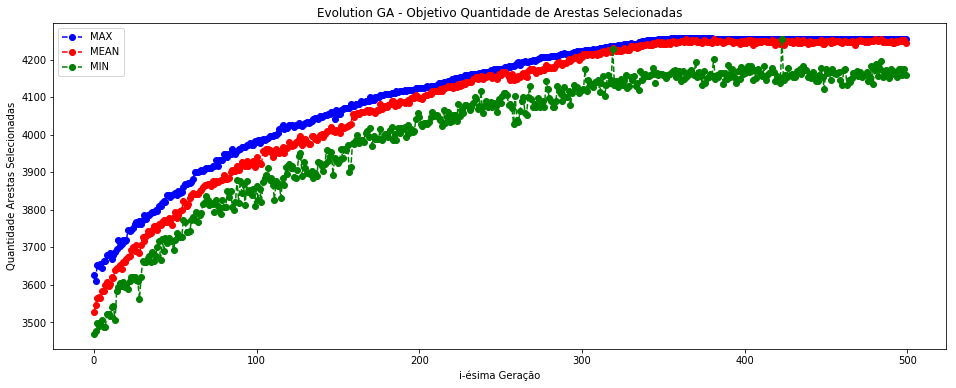

In [54]:
# fazer um tratamento se o maxdados for o valor de sinalização para remove-lo da lista para nao estragar o gráfico
plt.figure(figsize=(16,6))
plt.plot(PlotMaxDadosONEMAX, 'ob--' , label='MAX')
plt.plot(PlotMeanDadosONEMAX, 'or--' ,label='MEAN')
plt.plot(PlotMinDadosONEMAX, 'og--',label='MIN')
plt.xlabel('i-ésima Geração')
plt.ylabel('Quantidade Arestas Selecionadas')
plt.title('Evolution GA - Objetivo Quantidade de Arestas Selecionadas')
plt.legend(loc='upper left')
plt.savefig("images/2-GraficoONEMAX.pdf",format=formato_imgs)
#plt.show()


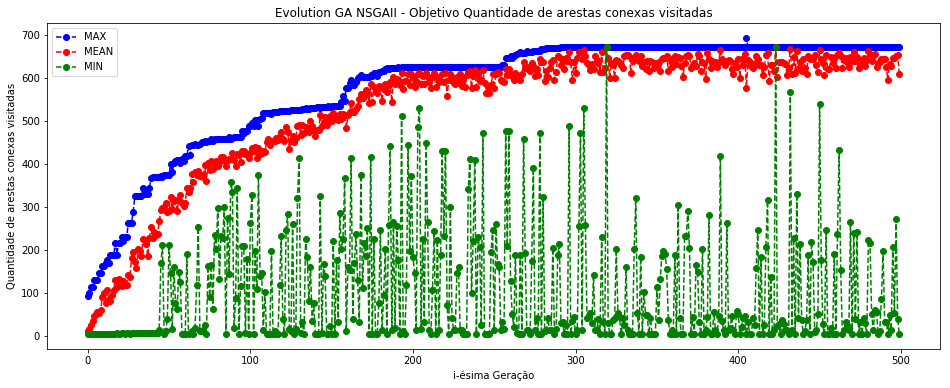

In [55]:
#
# fazer um tratamento se o maxdados for o valor de sinalização para remove-lo da lista para nao estragar o gráfico
plt.figure(figsize=(16,6))
plt.plot(PlotMaxDadosDFS, 'ob--' , label='MAX')
plt.plot(PlotMeanDadosDFS, 'or--' ,label='MEAN')
plt.plot(PlotMinDadosDFS, 'og--',label='MIN')
plt.xlabel('i-ésima Geração')
plt.ylabel('Quantidade de arestas conexas visitadas')
plt.title('Evolution GA NSGAII - Objetivo Quantidade de arestas conexas visitadas')
plt.legend(loc='upper left')
plt.savefig("images/2-GraficoDFS.pdf",format=formato_imgs)
#plt.show()


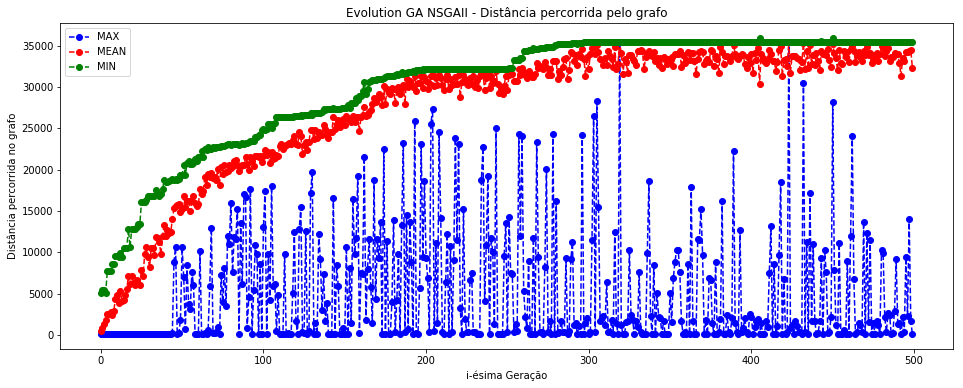

In [56]:
#
# Distancia percorrida DFS
plt.figure(figsize=(16,6))
plt.plot(PlotMinDistDFS, 'ob--' , label='MAX')
plt.plot(PlotMeanDistDFS, 'or--' ,label='MEAN')
plt.plot(PlotMaxDistDFS, 'og--',label='MIN')
plt.xlabel('i-ésima Geração')
plt.ylabel('Distância percorrida no grafo')
plt.title('Evolution GA NSGAII - Distância percorrida pelo grafo')
plt.legend(loc='upper left')
plt.savefig("images/2-GraficoDistanciaPercorridaDFS.pdf",format=formato_imgs)
#plt.show()

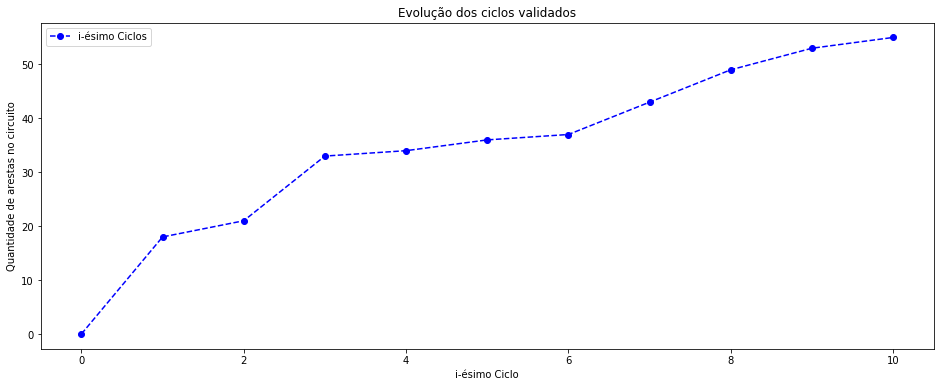

In [57]:
#
# Evolução dos ciclos encontrados
plt.figure(figsize=(16,6))
plt.plot(PlotMaioresCiclos, 'ob--' , label='i-ésimo Ciclos')
plt.xlabel('i-ésimo Ciclo')
plt.ylabel('Quantidade de arestas no circuito')
plt.title('Evolução dos ciclos validados')
plt.legend(loc='upper left')
plt.savefig("images/2-GraficoTamanhoCiclos.pdf",format=formato_imgs)
#plt.show()

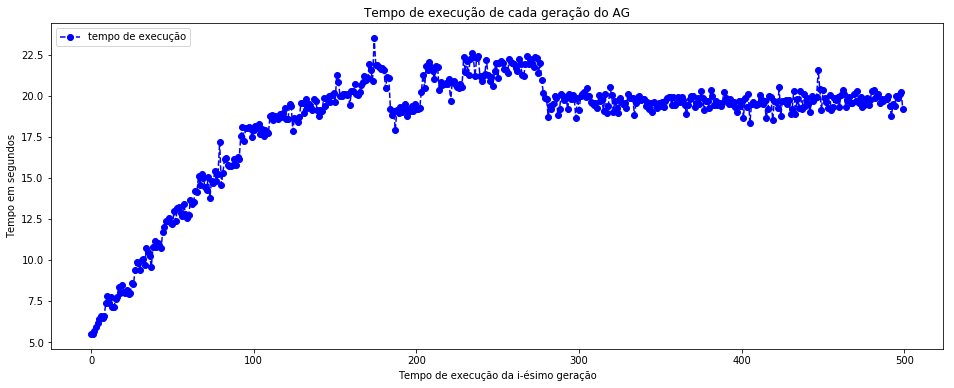

In [58]:
#
# Tempo
plt.figure(figsize=(16,6))
plt.plot(PlotTempoExecucao, 'ob--' , label='tempo de execução')
plt.xlabel('Tempo de execução da i-ésimo geração')
plt.ylabel('Tempo em segundos')
plt.title('Tempo de execução de cada geração do AG')
plt.legend(loc='upper left')
plt.savefig("images/2-GraficoTempo.pdf",format=formato_imgs)
#plt.show()

# Plotagem das rotas geradas caso tenha encontrado

In [59]:
def salvarRotaTxt(via_vez, rota):
    try:
        path = "Rotas/Rota-"+str(via_vez)+".txt"
        arq = open(path, 'w')    
        for linha in rota:
            arq.write(linha+"\n")        
        arq.close()
    except:
        print("Erro salvar rota..")
    
def printFormatNamesStreet( via_vez , qtd_arestas, ruas ):
    
    try:
        contador = 1
        salvarText = []

        # +1 por causa do retorno do ciclo da rota    
        Rota = "Rota "+str(via_vez)+" - "+str(qtd_arestas)+" Arestas:\n"
        print(Rota)
        salvarText.append(Rota)

        for rua in ruas:
            concat = str(rua)
            Rua = ""+str(contador)+"ª - "+concat
            print(Rua)
            salvarText.append(Rua)
            contador = contador + 1

        Rua = ""+str(contador)+"ª - "+ruas[0]
        print(Rua)
        salvarText.append(Rua)

        salvarRotaTxt(via_vez, salvarText)
    except:
        print("Erro pegar rota..")
        
def printRotaRuas(via_vez, qtd_arestas, rota ):
    
    try:
                
        tamListaDadosNew = len(listaDadosNew)
        tamRotaLista = len(rota)

        ruasRota = []

        '''
            Arrumar os nomes das ruas..
        '''


        for rota_i in range( tamRotaLista ):            
            for lista_i in range(tamListaDadosNew):            
                if( listaDadosNew[lista_i][0] == rota[rota_i][0] and listaDadosNew[lista_i][1] == rota[rota_i][1] ):

                    if 'name' in listaDadosNew[lista_i][2]:
                        rua = listaDadosNew[lista_i][2]['name']

                        if rua not in ruasRota:
                            ruasRota.append(rua)

                    else:
                        ruasRota.append("Unname")

                                    

        printFormatNamesStreet(via_vez, qtd_arestas, ruasRota )
        print("\n\n")

    except:
        print("Erro...")
        

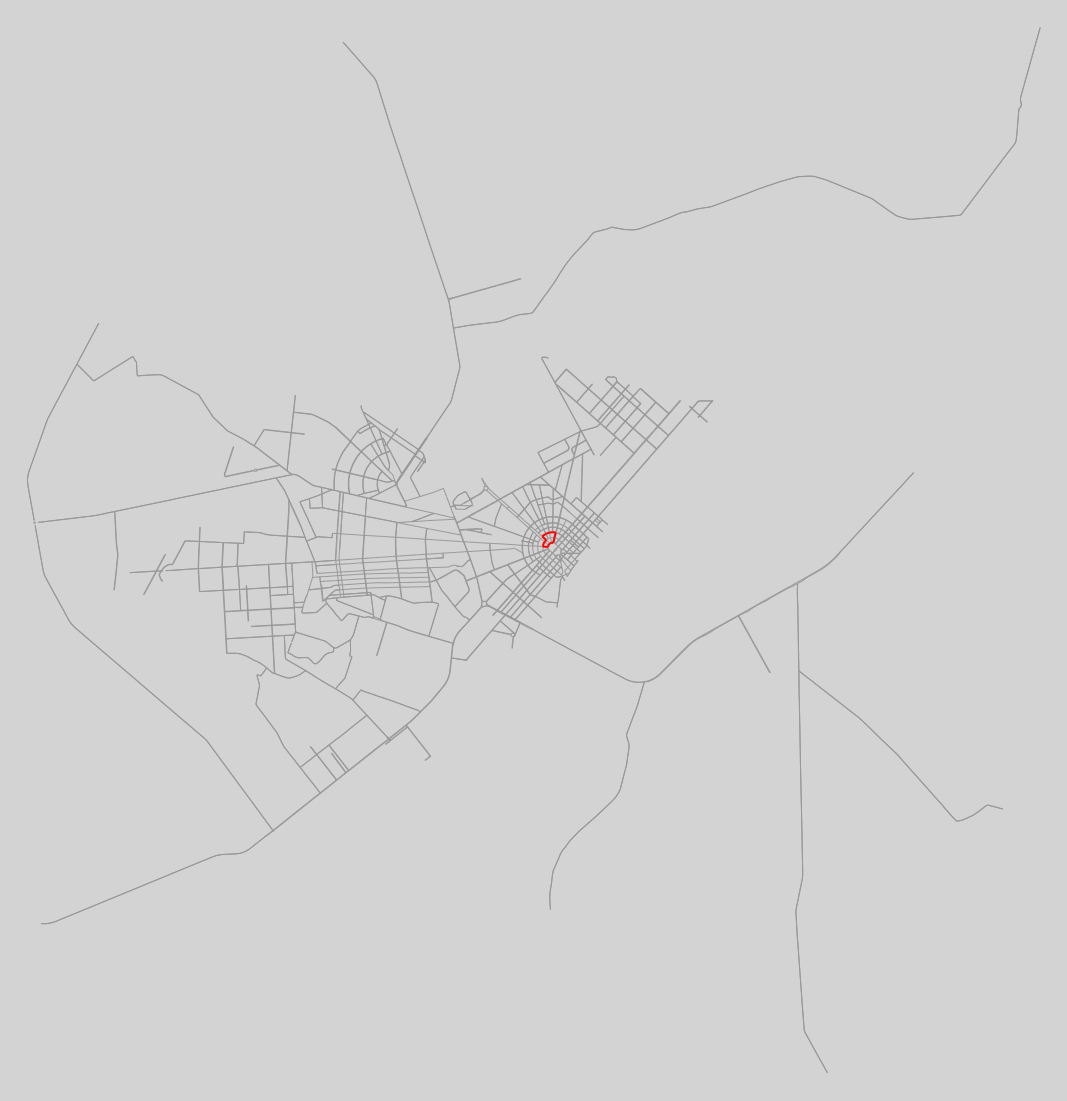



Rota 0 - 0 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Avenida Capitão Ene Garcêz
6ª - Rua Alfredo Cruz
7ª - Avenida Capitão Júlio Bezerra
8ª - Avenida Amazonas





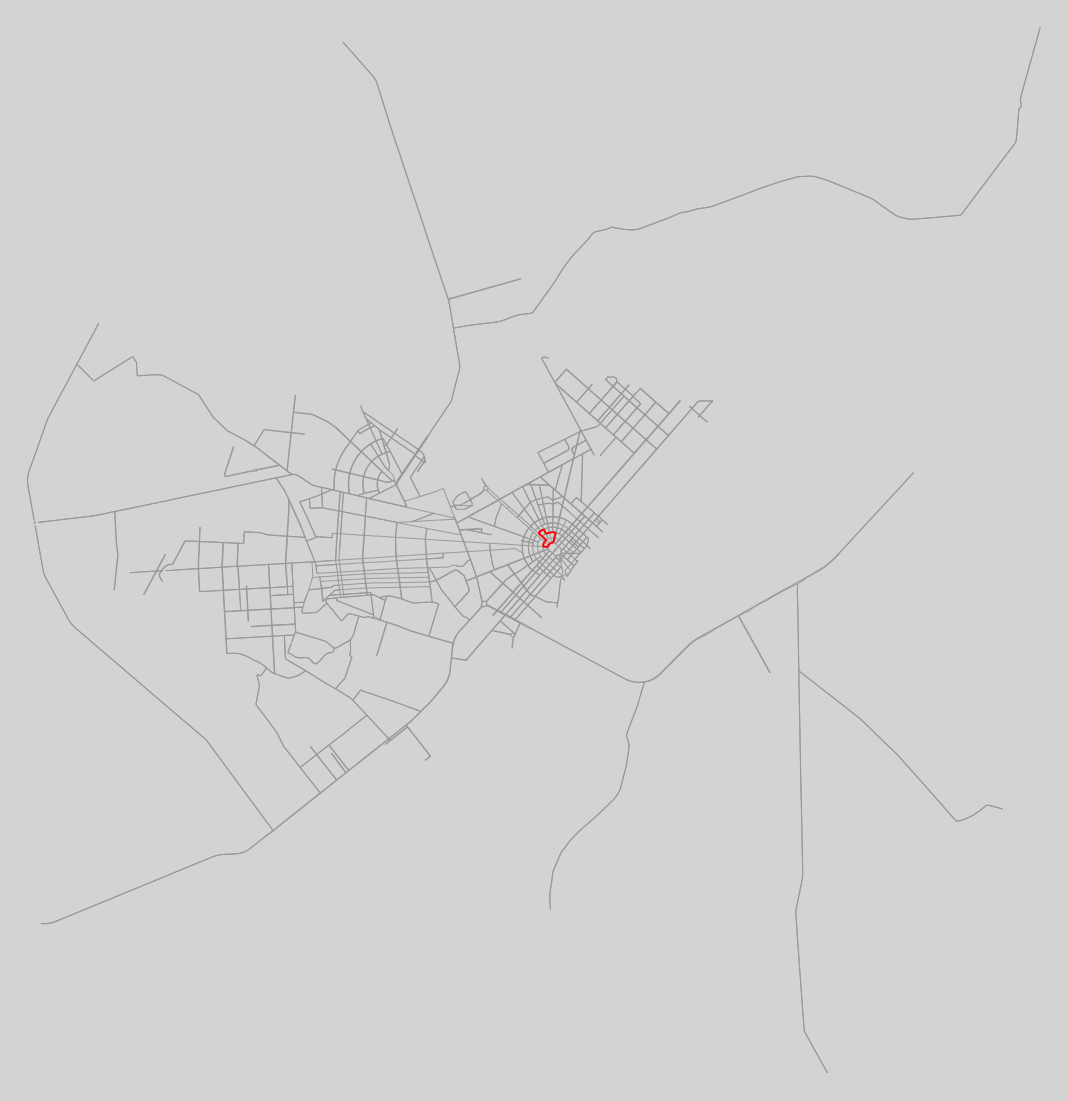



Rota 1 - 18 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Avenida Capitão Ene Garcêz
6ª - Rua Barão do Rio Branco
7ª - Rua General Penha Brasil
8ª - Rua Alfredo Cruz
9ª - Avenida Capitão Júlio Bezerra
10ª - Avenida Amazonas





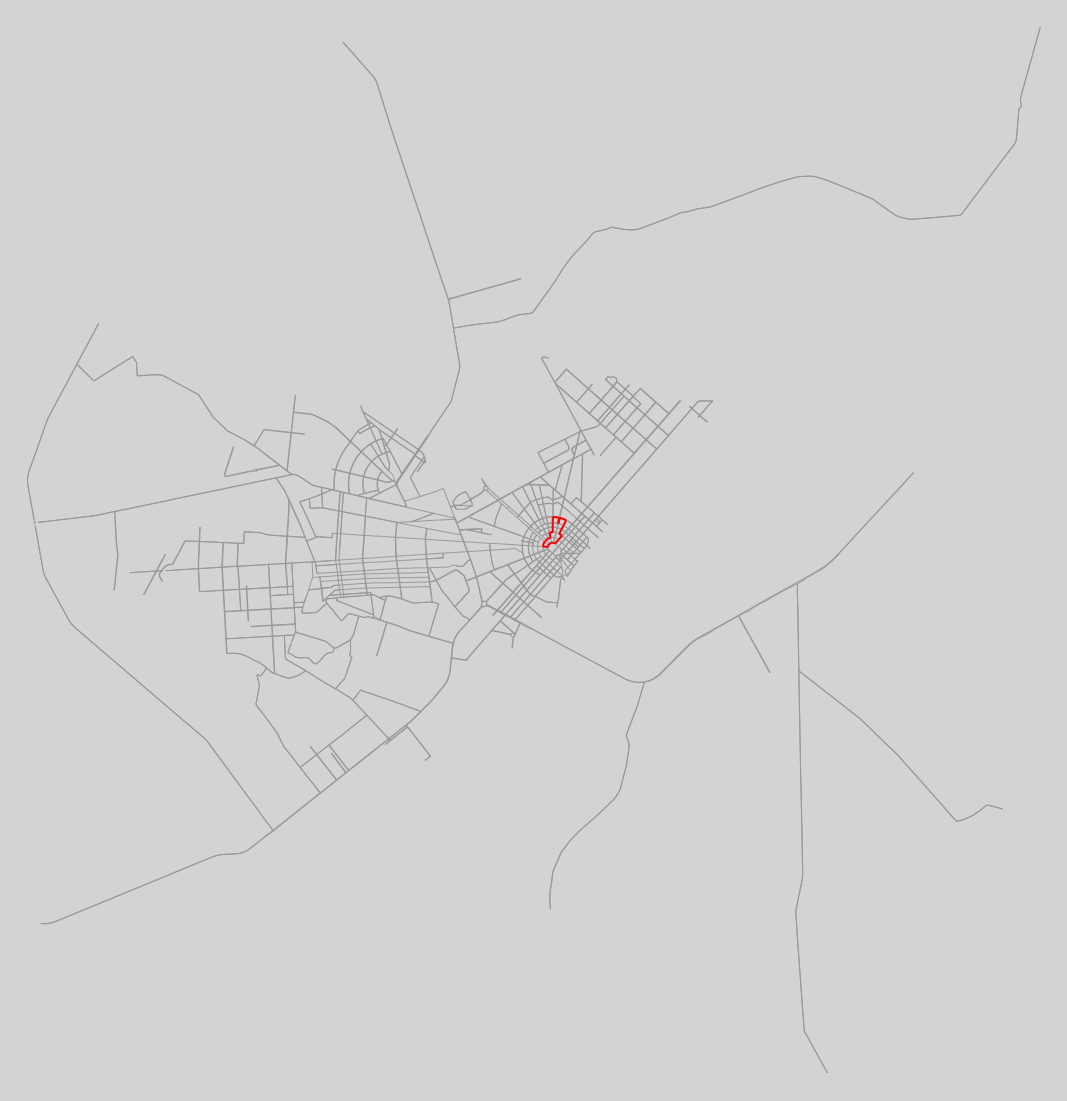



Rota 2 - 21 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua Professor Agnelo Bitencourt
7ª - Rua Alfredo Cruz
8ª - Rua Alferes Paulo Saldanha
9ª - Avenida Major Williams
10ª - Avenida Capitão Júlio Bezerra
11ª - Rua Coronel Mota
12ª - Rua Rocha Leal
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





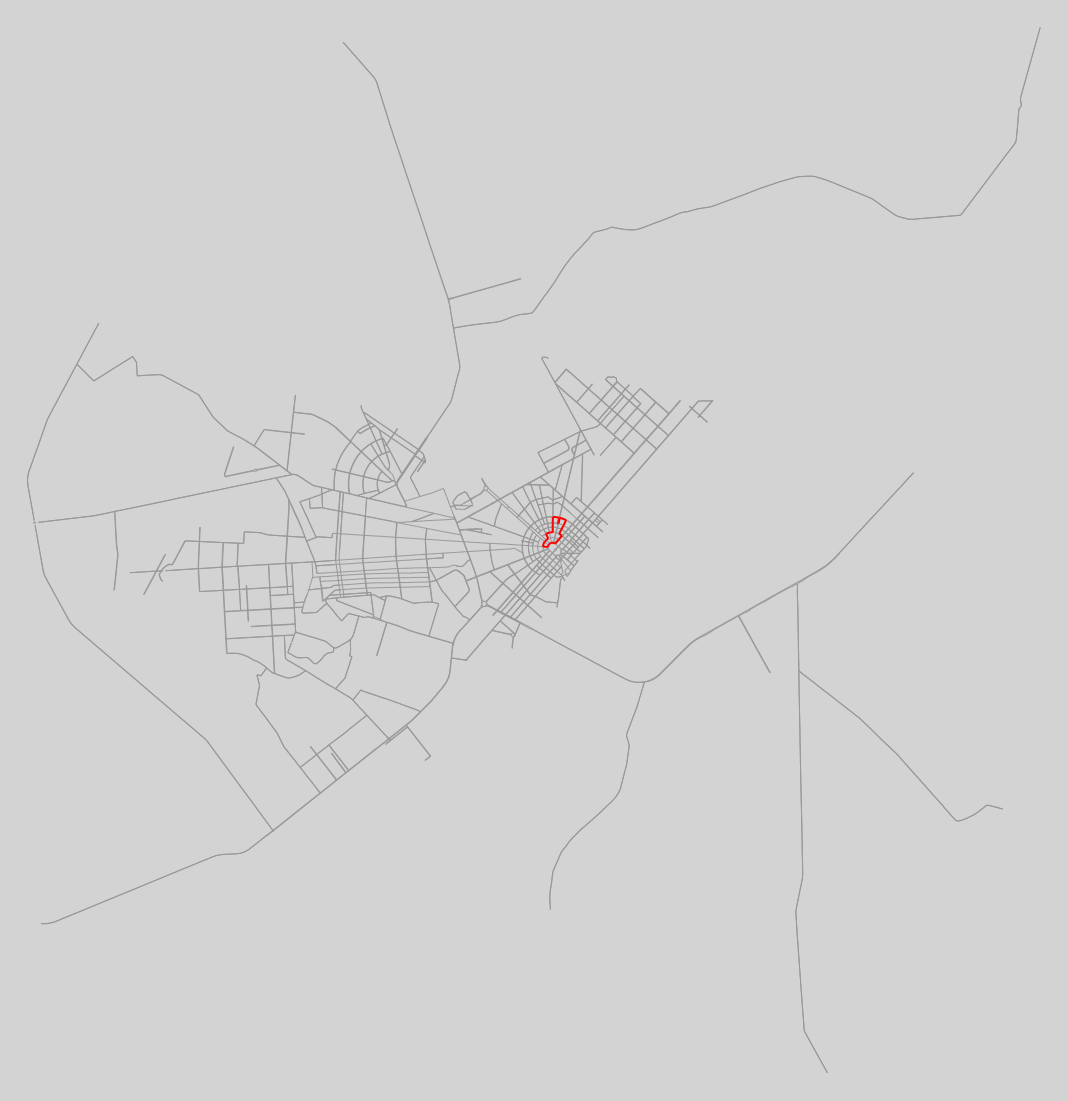



Rota 3 - 33 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Alfredo Cruz
8ª - Rua Alferes Paulo Saldanha
9ª - Avenida Major Williams
10ª - Avenida Capitão Júlio Bezerra
11ª - Rua Coronel Mota
12ª - Rua Rocha Leal
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





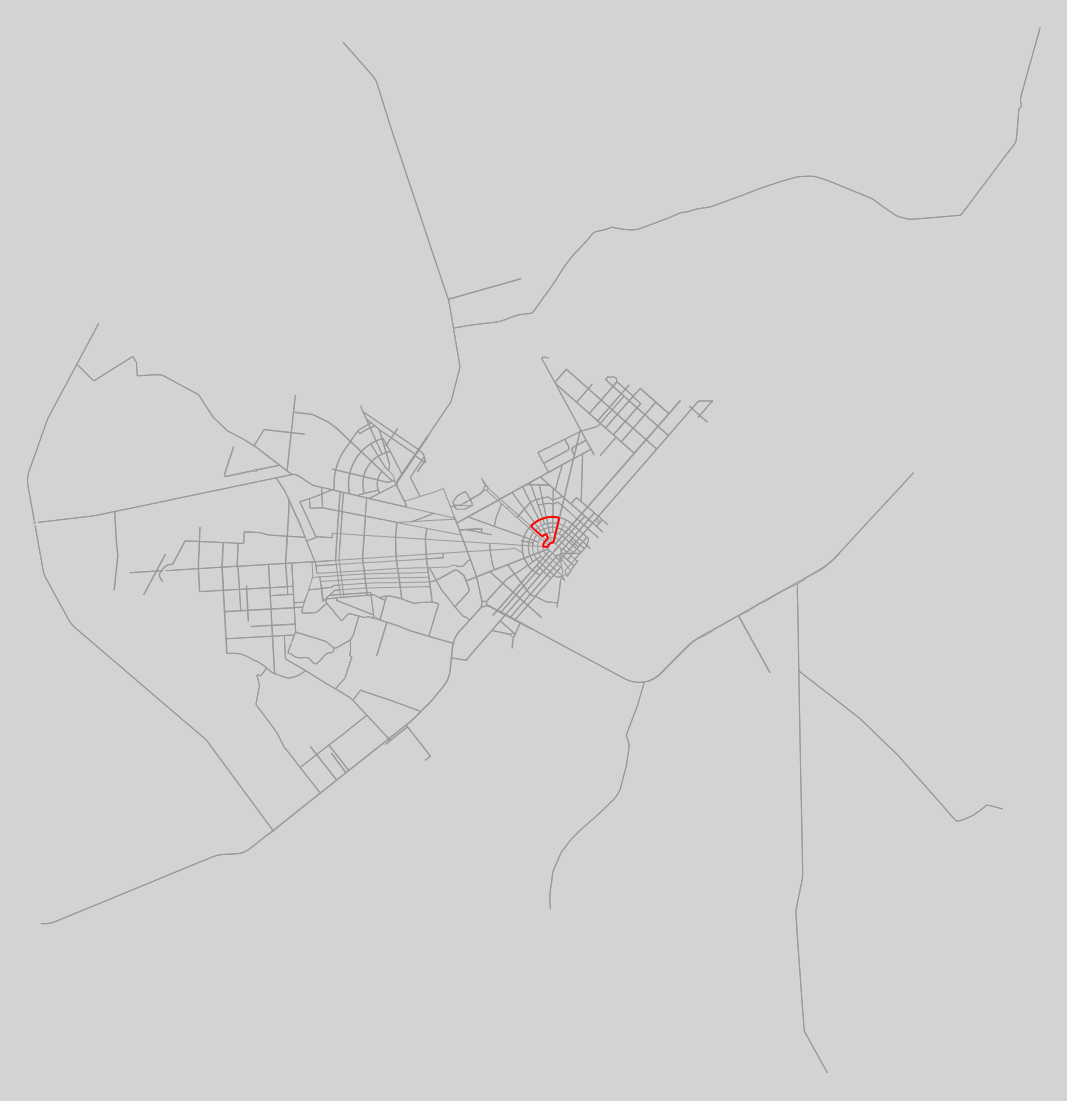



Rota 4 - 34 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Alfredo Cruz
8ª - Avenida Capitão Ene Garcêz
9ª - Avenida Capitão Ene Garcês
10ª - Avenida Major Williams
11ª - Avenida Capitão Júlio Bezerra
12ª - Avenida Amazonas





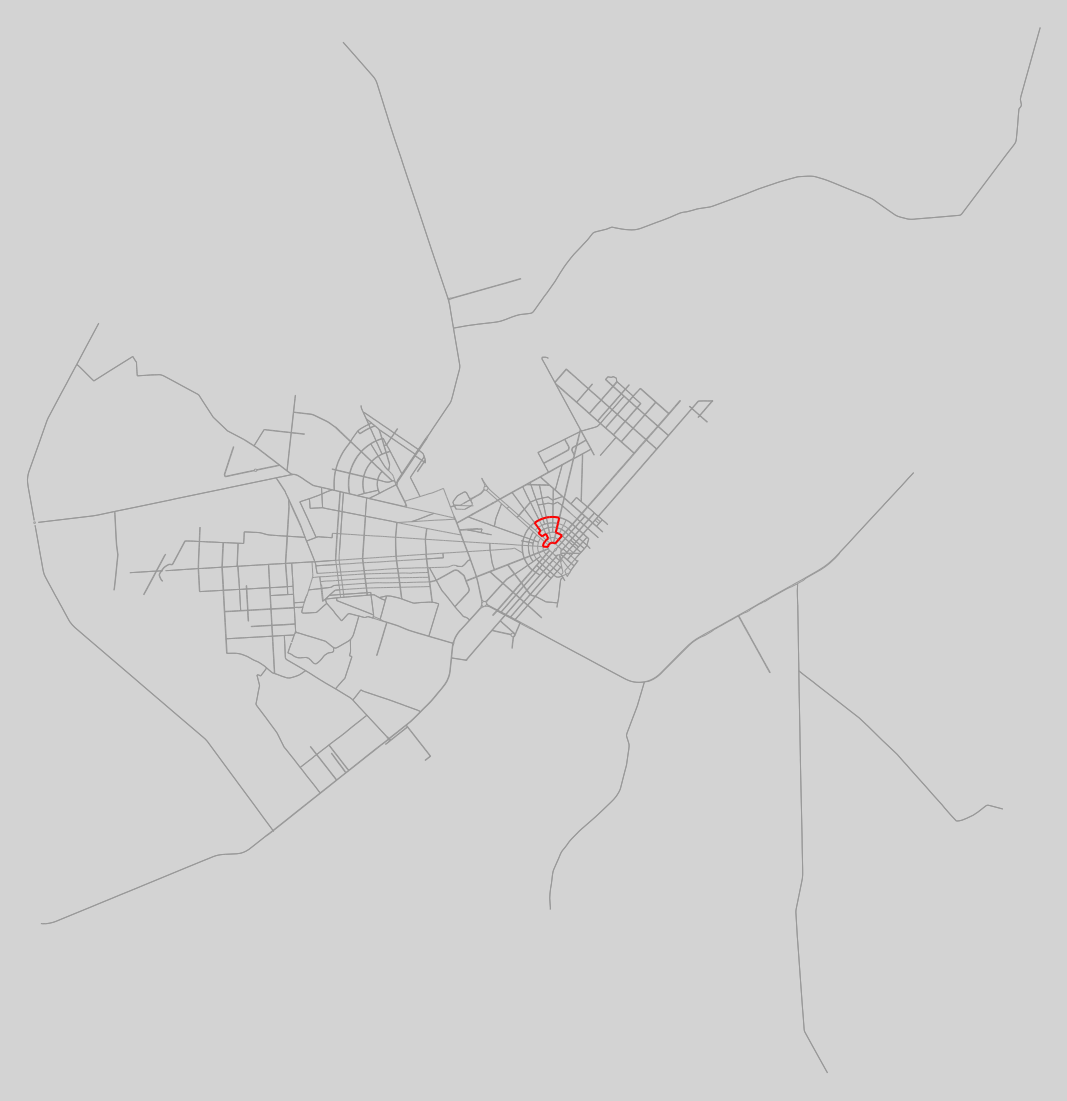



Rota 5 - 36 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Alfredo Cruz
8ª - Avenida Capitão Ene Garcêz
9ª - Rua Barão do Rio Branco
10ª - Rua Major Manoel Correia
11ª - Avenida Major Williams
12ª - Avenida Capitão Júlio Bezerra
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





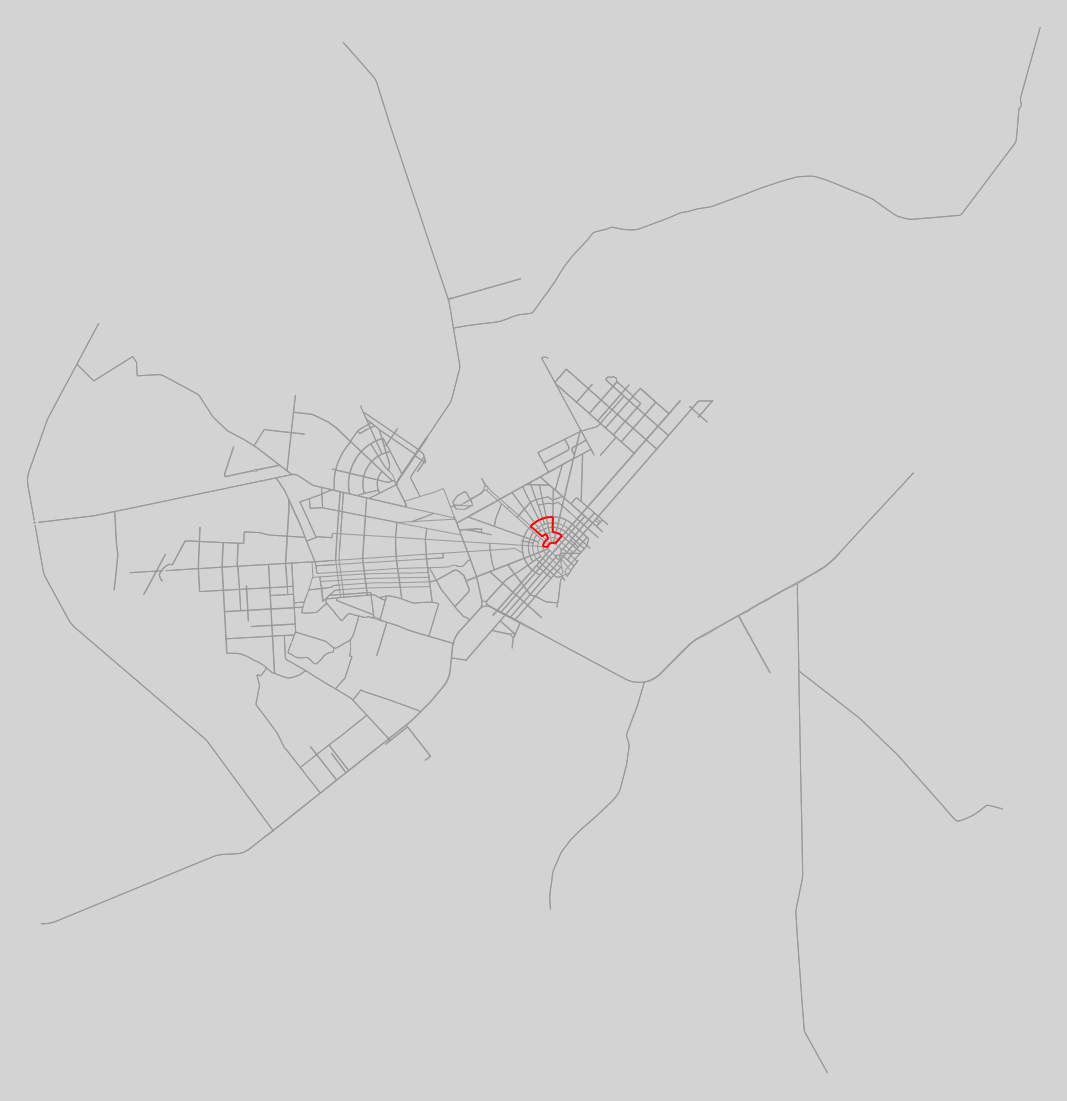



Rota 6 - 37 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Araújo Filho
4ª - Avenida Capitão Ene Garcez
5ª - Rua Coronel Pinto
6ª - Rua General Penha Brasil
7ª - Rua Alfredo Cruz
8ª - Avenida Capitão Ene Garcêz
9ª - Avenida Capitão Ene Garcês
10ª - Avenida Terêncio Lima
11ª - Avenida Major Williams
12ª - Rua Alferes Paulo Saldanha
13ª - Avenida Ville Roy
14ª - Avenida Amazonas





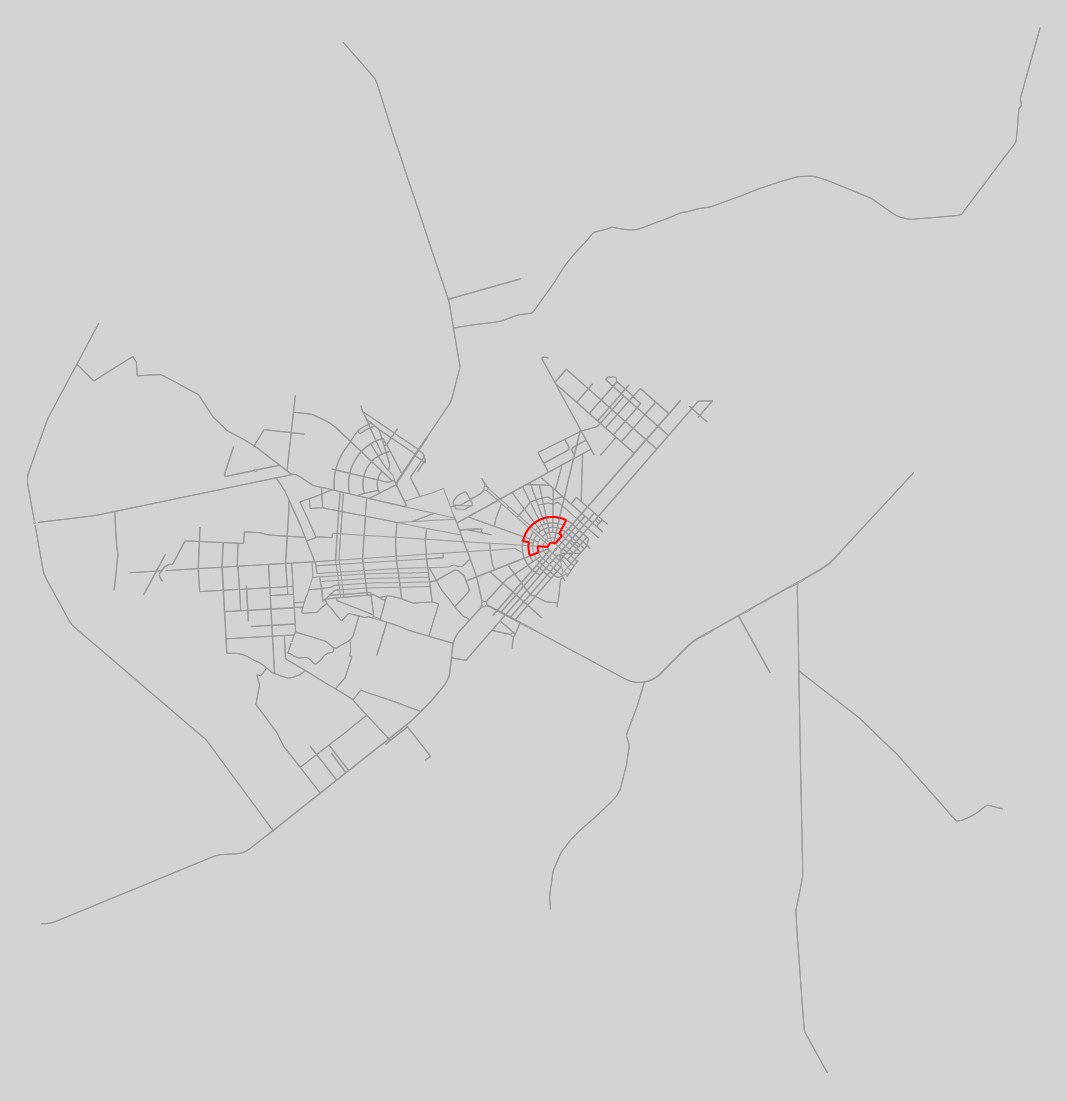



Rota 7 - 43 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Cecília Brasil
4ª - Avenida Glaycon de Paiva
5ª - Rua Cerejo Cruz
6ª - Rua Dom Pedro I
7ª - Avenida Terêncio Lima
8ª - Avenida Major Williams
9ª - Rua Rocha Leal
10ª - Rua Alfredo Cruz
11ª - Avenida Ville Roy
12ª - Avenida Amazonas





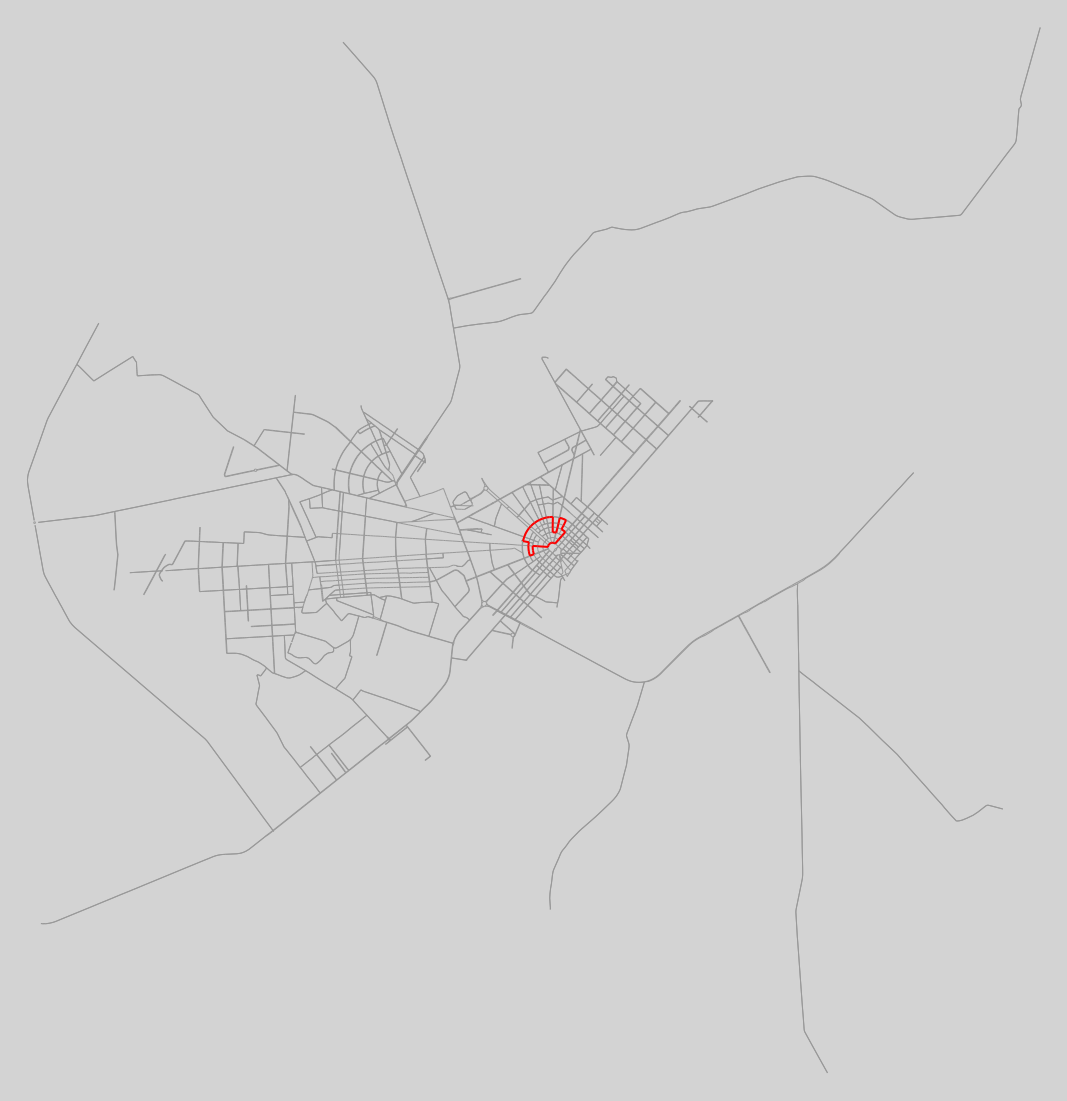



Rota 8 - 49 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Ajuricaba
4ª - Avenida Glaycon de Paiva
5ª - Rua Cerejo Cruz
6ª - Rua Dom Pedro I
7ª - Avenida Terêncio Lima
8ª - Avenida Major Williams
9ª - Rua Alferes Paulo Saldanha
10ª - Rua Alfredo Cruz
11ª - Avenida Capitão Júlio Bezerra
12ª - Rua Rocha Leal
13ª - Rua Barão do Rio Branco
14ª - Avenida Ville Roy
15ª - Avenida Amazonas





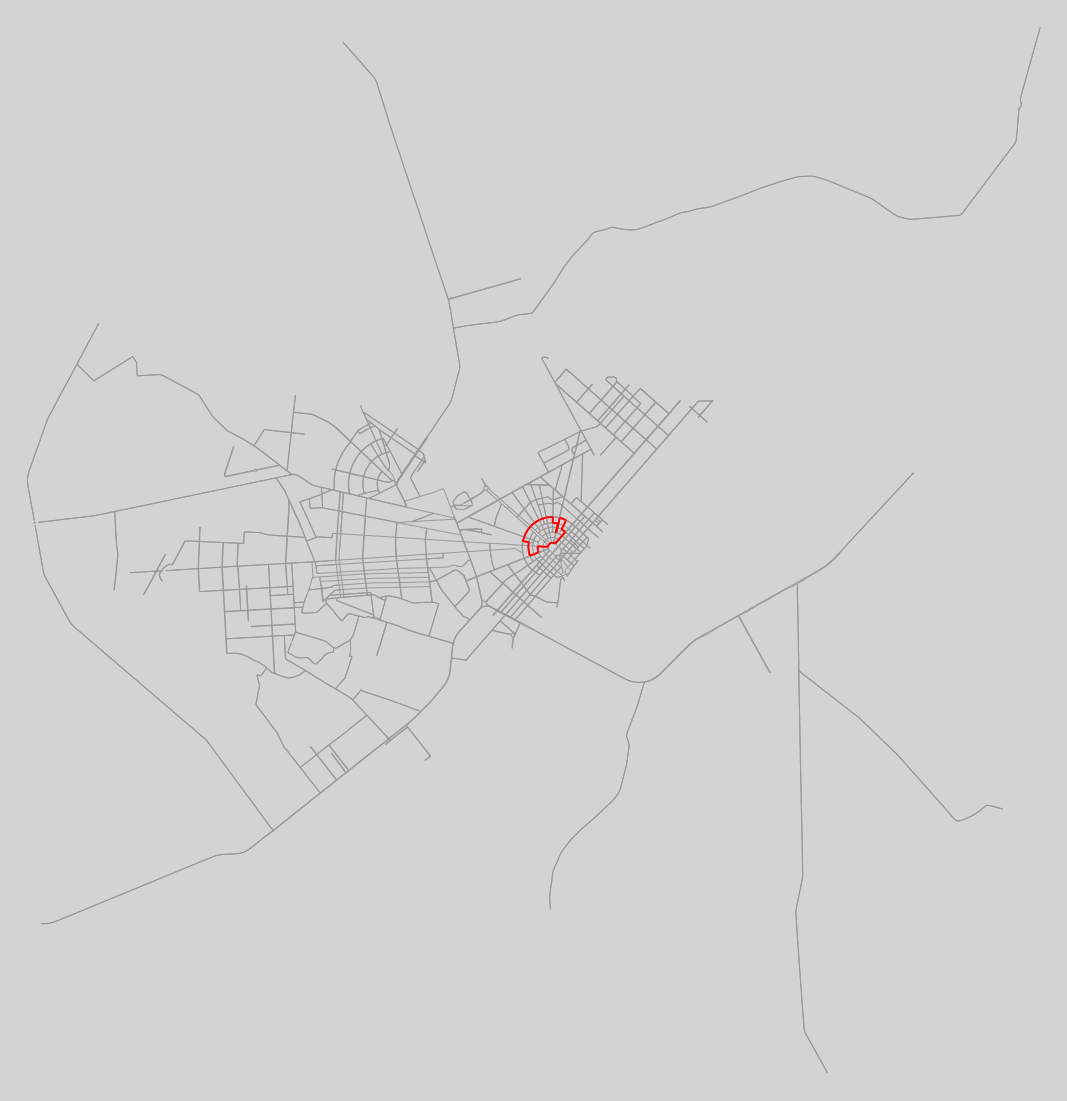



Rota 9 - 53 Arestas:

1ª - Avenida Amazonas
2ª - Avenida Mário Homem de Melo
3ª - Rua Cecília Brasil
4ª - Avenida Glaycon de Paiva
5ª - Rua Cerejo Cruz
6ª - Rua Dom Pedro I
7ª - Avenida Terêncio Lima
8ª - Avenida Major Williams
9ª - Rua Alferes Paulo Saldanha
10ª - Rua Coronel Mota
11ª - Avenida Capitão Júlio Bezerra
12ª - Rua Alfredo Cruz
13ª - Rua Rocha Leal
14ª - Rua Barão do Rio Branco
15ª - Avenida Ville Roy
16ª - Avenida Amazonas





In [60]:
removerNodosFinal = []
cont=1
contador = 0

if len(listaResultadoDFS) > 0:
    for cadaCicloEncontrado in range(len(listaResultadoDFS)):
        
        name = "2-Rota-"+ str(contador)

        arestas_sel = listaResultadoDFS[cadaCicloEncontrado]

        path = [ (u,v) for (u,v, attr) in G.edges(data=True) if (u,v) in arestas_sel]

        ox.plot.plot_graph_routes(G, path, show=True, fig_height=fig_height, fig_width=fig_width, bgcolor=bgcolor, route_alpha=1, route_linewidth=2, node_size=0 , orig_dest_node_alpha=0, filename=name, save=True,  file_format=formato_imgs )
        print("\n")

        printRotaRuas( contador, PlotMaioresCiclos[contador] , listaResultadoDFS[cadaCicloEncontrado] )
        contador = contador + 1
            
        
else:
    print("Infelizmente não foi possivel encontrar uma rota....")

 <h1 style="text-align: center;"> FIMMM --- Obrigado </h1>